# 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold
plt.style.use("ggplot")

## Load data and EDA

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [5]:
df_train.describe()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


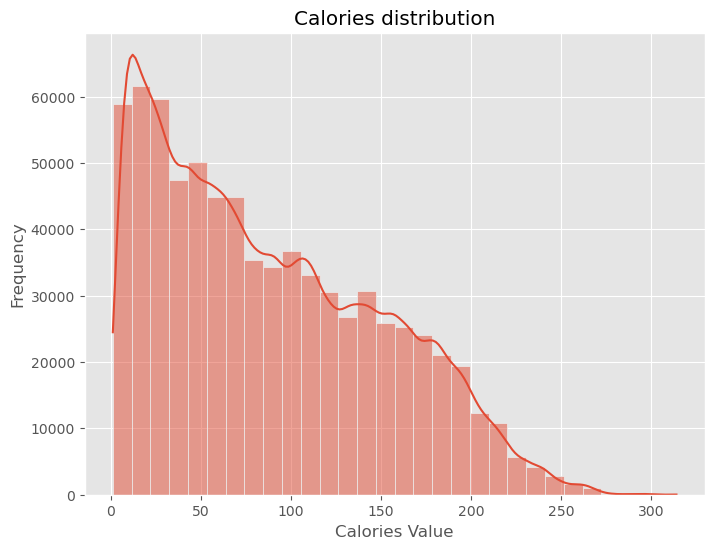

In [6]:
# Check the target variable's distribution
plt.figure(figsize=(8, 6))
sns.histplot(df_train['Calories'], bins=30, kde=True)
plt.title("Calories distribution")
plt.ylabel("Frequency")
plt.xlabel("Calories Value")
plt.show()

### Feature Distribution

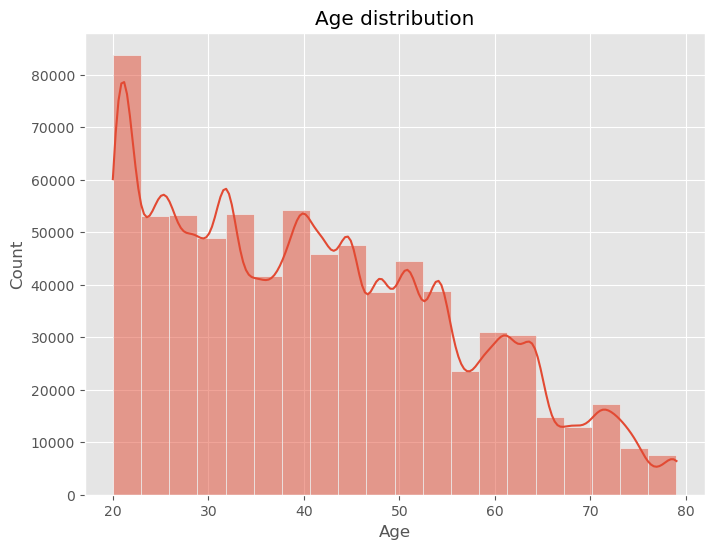

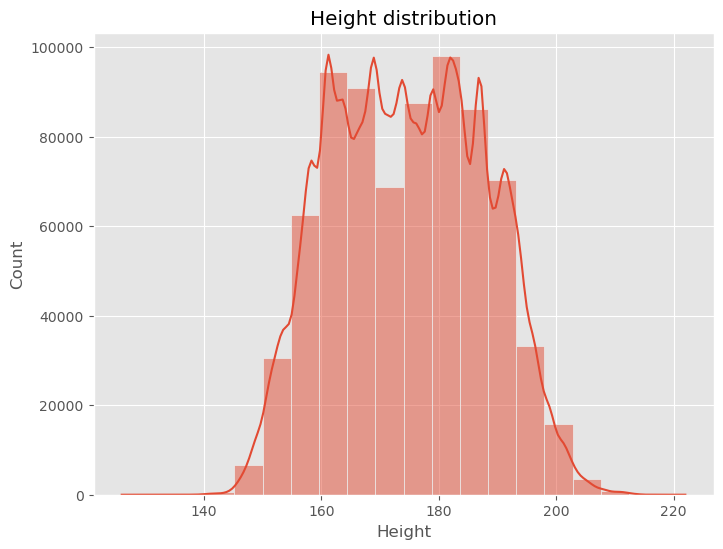

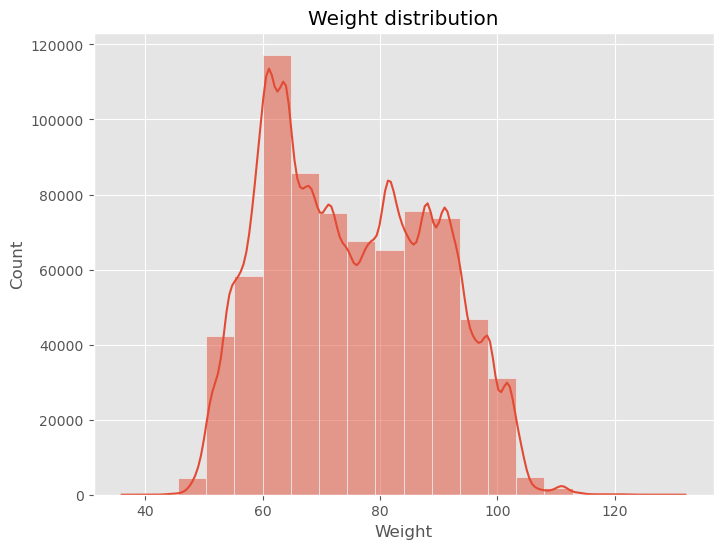

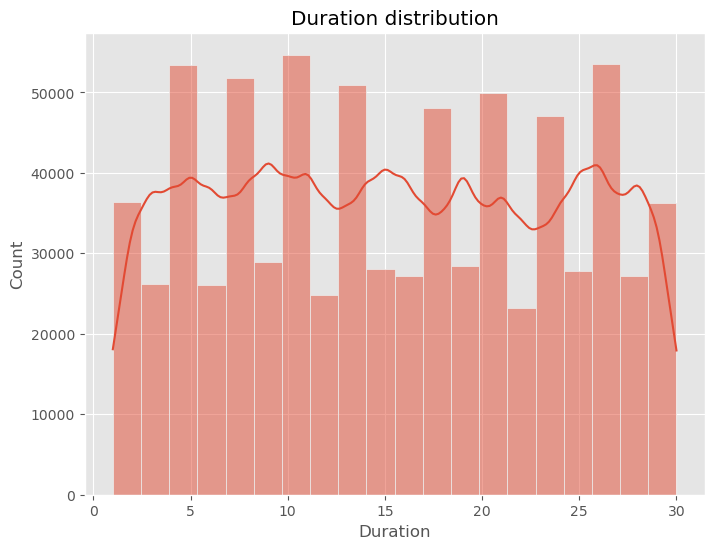

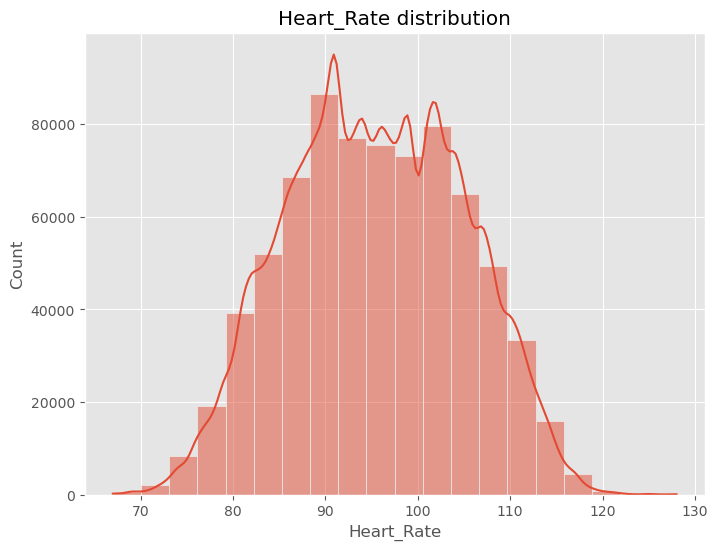

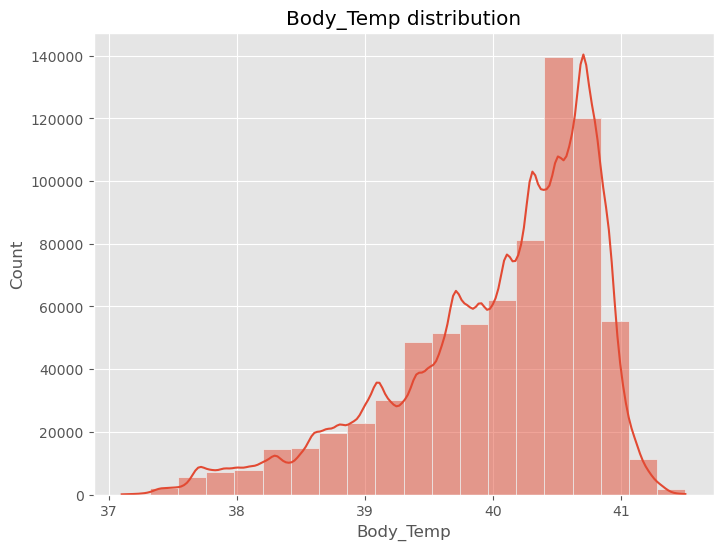

In [7]:
# Check the numeric feature distribution
numeric_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(df_train[feature], bins=20, kde=True)
    plt.title(f"{feature} distribution")
    plt.show()


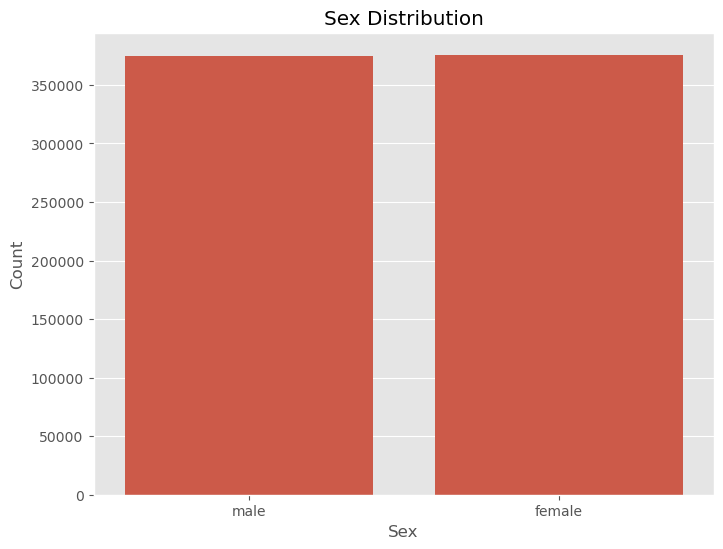

In [8]:
# Check the categorical feature distribution
categorical_feature = "Sex"
plt.figure(figsize=(8, 6))
sns.countplot(data=df_train, x=categorical_feature)
plt.title("Sex Distribution")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()


### Feature_Target Relationship

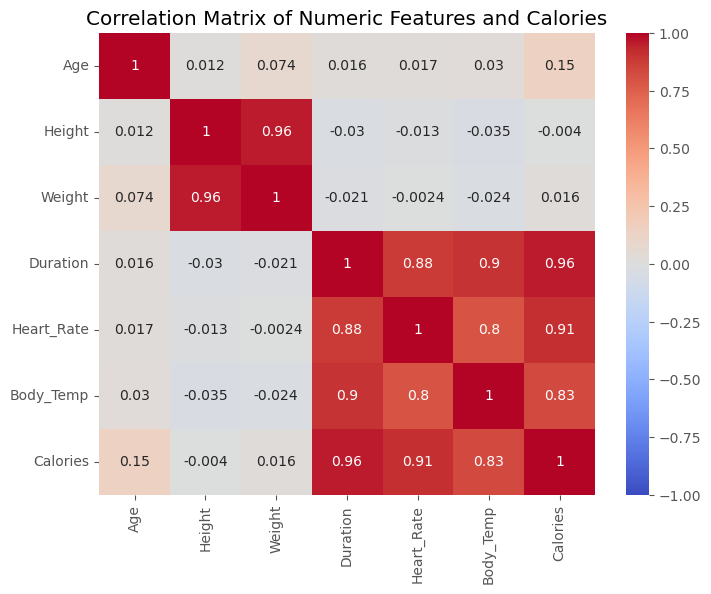

Calories      1.000000
Duration      0.959908
Heart_Rate    0.908748
Body_Temp     0.828671
Age           0.145683
Weight        0.015863
Height        0.004026
Name: Calories, dtype: float64


In [9]:
# One-hot encoding
df_train['Sex'] = df_train['Sex'].map({'male': 0, 'female': 1})
df_test['Sex'] = df_test['Sex'].map({'male': 0, 'female': 1})

# Correlation Matrix Heatmap
corr_matrix = df_train[numeric_features + ["Calories"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlation Matrix of Numeric Features and Calories")
plt.show()

# Correlations with Calories
print(corr_matrix["Calories"].abs().sort_values(ascending=False))

<Figure size 800x600 with 0 Axes>

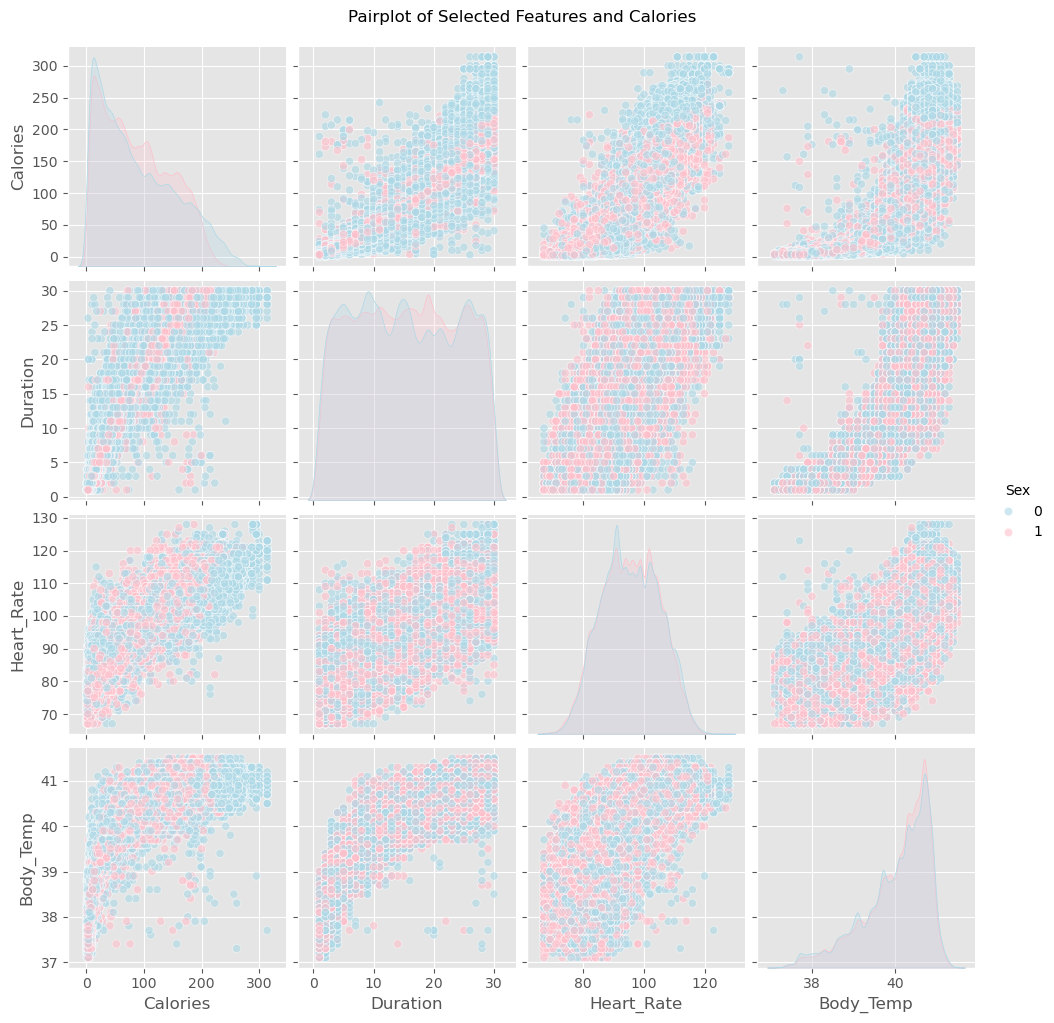

In [10]:
# Pairplots
plt.figure(figsize=(8, 6))
g = sns.pairplot(df_train, vars=["Calories", "Duration", "Heart_Rate", "Body_Temp"], diag_kind='kde', hue='Sex', plot_kws={'alpha':0.6}, palette={ 0 :'lightblue', 1 :'pink'})
g.fig.suptitle("Pairplot of Selected Features and Calories", y=1.02)
plt.show()

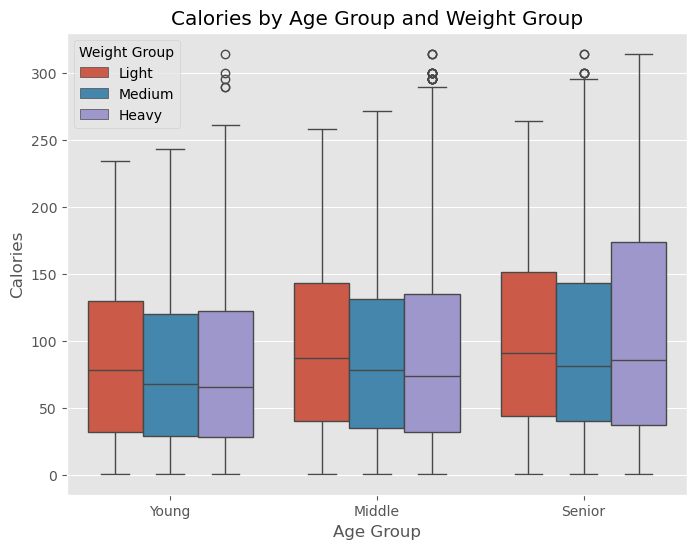

In [11]:
# Calories grouped by Age and Weight
df_train['Age_Group'] = pd.cut(df_train['Age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle', 'Senior'])
df_train['Weight_Group'] = pd.cut(df_train['Weight'], bins=[0, 60, 80, 120], labels=['Light', 'Medium', 'Heavy'])

# Analyze Calories by Age_Group and Weight_Group
plt.figure(figsize=(8,6))
sns.boxplot(df_train, x='Age_Group', y='Calories', hue='Weight_Group')
plt.title('Calories by Age Group and Weight Group')
plt.xlabel('Age Group')
plt.ylabel('Calories')
plt.legend(title='Weight Group')
plt.show()

## Data Preprocessing and Feature Engineering

In [13]:
def feature_engineer(df):
    df_eng = df.copy()

    # Sex mapping
    df_eng['Sex'] = df_eng['Sex'].map({'male': 0, 'female': 1})

    # BMI 
    df_eng['BMI'] = df_eng['Weight'] / ((df_eng['Height'] / 100) ** 2)
    # 处理BMI计算中可能产生的inf值
    df_eng['BMI'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # Group age
    age_bins = [0, 30, 50, 100]
    age_labels = [0, 1, 2] 
    df_eng['Age_Group'] = pd.cut(df_eng['Age'], bins=age_bins, labels=age_labels, right=False, include_lowest=True)
    # pd.cut 返回的是 Categorical 类型，如果打算用中位数填充它（虽然众数可能更合适），
    # 需要先转成可以计算中位数的类型，或者在 fillna 时特殊处理。
    # 但由于我们后续会将其转为int，这里暂时保持不变，让下面的 fillna 处理。

    # Group weight
    weight_bins = [0, 60, 80, 150] 
    weight_labels = [0, 1, 2] 
    df_eng['Weight_Group'] = pd.cut(df_eng['Weight'], bins=weight_bins, labels=weight_labels, right=False, include_lowest=True)

    # Create Interaction Features
    df_eng['Duration_x_HeartRate'] = df_eng['Duration'] * df_eng['Heart_Rate']
    df_eng["HeartRate_per_Duration"] = df_eng["Heart_Rate"] / (df_eng["Duration"] + 1e-6) 
    # 处理HeartRate_per_Duration可能产生的inf值
    df_eng["HeartRate_per_Duration"].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    df_eng['Sex_x_Duration'] = df_eng['Sex'] * df_eng['Duration']
    df_eng['Age_x_BMI'] = df_eng['Age'] * df_eng['BMI']
    # 处理Age_x_BMI可能产生的inf值 (如果BMI是inf)
    df_eng['Age_x_BMI'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # --- 核心修改在这里 ---
    # 1. 先用众数填充分类编码的特征中的NaN (如果存在)
    #    pd.cut 加上 include_lowest=True 通常能避免因边界值产生的NaN
    #    但如果原始 Age 或 Weight 列就有 NaN，那么cut之后还是NaN
    if 'Age_Group' in df_eng.columns and df_eng['Age_Group'].isnull().any():
        df_eng['Age_Group'].fillna(df_eng['Age_Group'].mode()[0], inplace=True)
    if 'Weight_Group' in df_eng.columns and df_eng['Weight_Group'].isnull().any():
        df_eng['Weight_Group'].fillna(df_eng['Weight_Group'].mode()[0], inplace=True)
        
    # 2. 将这些分类编码的特征转换为数值型(比如int)，这样它们才能被下面的median()处理(如果仍有NaN)
    #    或者，如果已经用众数填充完毕，这里转为int是最终目标类型
    if 'Age_Group' in df_eng.columns:
         df_eng['Age_Group'] = df_eng['Age_Group'].astype(int)
    if 'Weight_Group' in df_eng.columns:
         df_eng['Weight_Group'] = df_eng['Weight_Group'].astype(int)

    # 3. 用中位数填充剩余所有列（主要是数值列）的NaN
    #    df_eng.median(numeric_only=True) 会只计算数值列的中位数
    #    然后 fillna 会用这些计算出来的中位数去填充对应列的NaN
    medians = df_eng.median(numeric_only=True) # 只计算数值列的中位数
    df_eng.fillna(medians, inplace=True)
    
    # 如果经过以上步骤，某些非数值列（如果还有的话）仍然有NaN，需要单独处理
    # 但根据你的特征工程，大部分应该是数值型了

    return df_eng

df_train_eng = feature_engineer(df_train.copy())
df_test_eng = feature_engineer(df_test.copy())

C:\Users\16254\AppData\Local\Temp\ipykernel_11612\3003574269.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_eng['BMI'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\16254\AppData\Local\Temp\ipykernel_11612\3003574269.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

In [14]:
# Denfine feature columns to make sure all features exist in datasets
feature_columns = [
    'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', # original features
    'BMI', 'Age_Group', 'Weight_Group', # created features
    'Duration_x_HeartRate', 'HeartRate_per_Duration', 'Sex_x_Duration', 'Age_x_BMI' # Interaction Features
]
numeric_features_to_scale = [
    'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
    'BMI', 'Duration_x_HeartRate', 'HeartRate_per_Duration', 'Sex_x_Duration', 'Age_x_BMI'
]

# Split features X and target y for train data
X = df_train_eng[feature_columns]
y = np.log1p(df_train_eng['Calories']) # Log Transformation for reducing Skewness

# Create features X for test data
X_test = df_test_eng[feature_columns]

# Split the data into train sets and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard numeric features
scaler = StandardScaler()
X_train[numeric_features_to_scale] = scaler.fit_transform(X_train[numeric_features_to_scale])
X_val[numeric_features_to_scale] = scaler.transform(X_val[numeric_features_to_scale])
X_test[numeric_features_to_scale] = scaler.transform(X_test[numeric_features_to_scale])



c:\Users\16254\anaconda3\envs\calorie_predict\lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\16254\anaconda3\envs\calorie_predict\lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\16254\anaconda3\envs\calorie_predict\lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\16254\AppData\Local\Temp\ipykernel_11612\1981120658.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numeric_features_to_scale] = scaler.

## Model Training

### XGBoost

In [16]:
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1500,      # 增加了迭代次数
    learning_rate=0.02,     # 稍小的学习率
    max_depth=7,            # 树的深度
    subsample=0.75,         # 子采样比例
    colsample_bytree=0.75,  # 列采样比例
    random_state=42,
    tree_method='hist',     # 推荐使用 'hist' 加速
    early_stopping_rounds=100, # 早停轮数
    reg_alpha=0.05,          # L1 正则化
    reg_lambda=0.05           # L2 正则化
)

xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=100) # 每100轮打印一次日志

# 预测测试集 (log尺度)
y_pred_test_xgb_log = xgb_model.predict(X_test)
# 转换回原始尺度
y_pred_test_xgb = np.expm1(y_pred_test_xgb_log)
# 确保预测结果非负
y_pred_test_xgb[y_pred_test_xgb < 0] = 0

Training XGBoost...
[0]	validation_0-rmse:0.94356
[100]	validation_0-rmse:0.14921
[200]	validation_0-rmse:0.07260
[300]	validation_0-rmse:0.06878
[400]	validation_0-rmse:0.06839
[500]	validation_0-rmse:0.06827
[600]	validation_0-rmse:0.06819
[700]	validation_0-rmse:0.06814
[800]	validation_0-rmse:0.06811
[900]	validation_0-rmse:0.06808
[1000]	validation_0-rmse:0.06806
[1100]	validation_0-rmse:0.06805
[1191]	validation_0-rmse:0.06805


### LightGBM

In [17]:
print("Training LightGBM...")
lgb_model = lgb.LGBMRegressor(
    objective='regression_l1', # MAE损失函数，对异常值更鲁棒
    metric='rmse',             # 在log尺度上用RMSE评估
    n_estimators=1500,
    learning_rate=0.02,
    num_leaves=50,             # 适当增加叶子数量
    max_depth=9,               # 树的深度
    subsample=0.75,
    colsample_bytree=0.75,
    reg_alpha=0.05,
    reg_lambda=0.05,
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(100, verbose=100)])

# 预测测试集 (log尺度)
y_pred_test_lgb_log = lgb_model.predict(X_test)
# 转换回原始尺度
y_pred_test_lgb = np.expm1(y_pred_test_lgb_log)
y_pred_test_lgb[y_pred_test_lgb < 0] = 0

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1384
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 12
[LightGBM] [Info] Start training from score 4.356709
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	valid_0's rmse: 0.0693478


### CatBoost

In [18]:
print("Training CatBoost...")
# 如果你的 X_train_s 是DataFrame，可以指定类别特征列名
# 假设 'Sex', 'Age_Group', 'Weight_Group' 是你编码后的类别特征的列名
# categorical_features_names = ['Sex', 'Age_Group', 'Weight_Group']
# cat_features_for_cb = [X_train_s.columns.get_loc(col) for col in categorical_features_names if col in X_train_s.columns]
# 如果它们不在 X_train_s.columns 中 (比如你用了Numpy array)，你需要手动指定它们的列索引

# 为了简单，如果所有特征已经是数值型，可以不特别指定 cat_features，CatBoost也能处理
# 但如果能指定，效果可能更好
cat_model = cb.CatBoostRegressor(
    iterations=1500,
    learning_rate=0.02,
    depth=7,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=100,
    l2_leaf_reg=2, # L2正则化
    border_count=64
)

# 如果 X_train_s 是 DataFrame，并且你想指定类别特征:
# cat_features_to_specify = [col for col in ['Sex', 'Age_Group', 'Weight_Group'] if col in X_train_s.columns]

cat_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)]
              # cat_features=cat_features_to_specify # 如果你想显式指定
             )

# 预测测试集 (log尺度)
y_pred_test_cat_log = cat_model.predict(X_test)
# 转换回原始尺度
y_pred_test_cat = np.expm1(y_pred_test_cat_log)
y_pred_test_cat[y_pred_test_cat < 0] = 0

Training CatBoost...
0:	learn: 0.9452112	test: 0.9443799	best: 0.9443799 (0)	total: 249ms	remaining: 6m 13s
100:	learn: 0.1700313	test: 0.1695544	best: 0.1695544 (100)	total: 4.65s	remaining: 1m 4s
200:	learn: 0.0808675	test: 0.0804384	best: 0.0804384 (200)	total: 8.49s	remaining: 54.8s
300:	learn: 0.0724629	test: 0.0721902	best: 0.0721902 (300)	total: 12.3s	remaining: 49.1s
400:	learn: 0.0707569	test: 0.0706599	best: 0.0706599 (400)	total: 16s	remaining: 43.9s
500:	learn: 0.0699076	test: 0.0700225	best: 0.0700225 (500)	total: 19.6s	remaining: 39.1s
600:	learn: 0.0692980	test: 0.0695903	best: 0.0695903 (600)	total: 23.2s	remaining: 34.8s
700:	learn: 0.0688142	test: 0.0692676	best: 0.0692676 (700)	total: 26.9s	remaining: 30.7s
800:	learn: 0.0684443	test: 0.0690472	best: 0.0690472 (800)	total: 30.6s	remaining: 26.7s
900:	learn: 0.0681557	test: 0.0688819	best: 0.0688819 (900)	total: 34.3s	remaining: 22.8s
1000:	learn: 0.0679136	test: 0.0687511	best: 0.0687511 (1000)	total: 38s	remaining: 

## Ensemble Predictions and Submission

In [19]:
# 简单平均融合
y_pred_final_ensemble = (y_pred_test_xgb + y_pred_test_lgb + y_pred_test_cat) / 3
y_pred_final_ensemble[y_pred_final_ensemble < 0] = 0

submission_ensemble = pd.DataFrame({'id': df_test['id'], 'Calories': y_pred_final_ensemble})
submission_ensemble.to_csv('submission_ensemble.csv', index=False)
print("\nSubmission file for Ensemble (submission_ensemble.csv) created.")

# 你也可以保存单个模型的预测结果
submission_xgb_df = pd.DataFrame({'id': df_test['id'], 'Calories': y_pred_test_xgb})
submission_xgb_df.to_csv('submission_xgb.csv', index=False)
print("Submission_xgb.csv created.")

submission_lgb_df = pd.DataFrame({'id': df_test['id'], 'Calories': y_pred_test_lgb})
submission_lgb_df.to_csv('submission_lgb.csv', index=False)
print("Submission_lgb.csv created.")

submission_cat_df = pd.DataFrame({'id': df_test['id'], 'Calories': y_pred_test_cat})
submission_cat_df.to_csv('submission_cat.csv', index=False)
print("Submission_cat.csv created.")


Submission file for Ensemble (submission_ensemble.csv) created.
Submission_xgb.csv created.
Submission_lgb.csv created.
Submission_cat.csv created.
